## Set initial file

In [1]:
# %load ade-model.py
import numpy as np
import math

#Author: Wouter Edeling

#solves the steady advection diffusion equation at Peclet number Pe and 
#constant forcing term f, using Finite Elements with linear shape functions.
def solve(f, nel=200, Pe = 100):

    #print('Solving advection diffusion equation at Pe = ', Pe, ' and f = ', f)
    h = 1.0/nel

    K = np.zeros([nel + 1, nel + 1])
    F = np.zeros(nel + 1)

    # GQ RULES
    Q = 2
    eps_i = np.array([-1 / math.sqrt(3.0), 1 / math.sqrt(3.0)])
    wi = np.ones(2)

    # assumble K matrix and F vector
    for e in range(nel):

        XA1 = e * h
        XA2 = (e + 1) * h

        x = (h * eps_i + XA1 + XA2) / 2

        [N1x, N2x] = der_shape(h, Q)
        [N1, N2] = shape(x, XA1, XA2)

        # diffusive term
        k11 = 1.0 / Pe * N1x * N1x * wi - N1x * N1 * wi
        k11 = k11.sum()
        k12 = 1.0 / Pe * N1x * N2x * wi - N1x * N2 * wi
        k12 = k12.sum()
        k21 = 1.0 / Pe * N2x * N1x * wi - N2x * N1 * wi
        k21 = k21.sum()
        k22 = 1.0 / Pe * N2x * N2x * wi - N2x * N2 * wi
        k22 = k22.sum()

        # forcing term
        f1 = N1 * f
        f1 = f1.sum()
        f2 = N2 * f
        f2 = f2.sum()

        # local element matrices
        if e > 0 and e < int(nel - 1):
            K[e, e] = K[e, e] + k11
            K[e, e + 1] = K[e, e + 1] + k12
            K[e + 1, e] = K[e + 1, e] + k21
            K[e + 1, e + 1] = K[e + 1, e + 1] + k22

            F[e] = F[e] + f1
            F[e + 1] = F[e + 1] + f2
        elif e == 0:
            K[e + 1, e] = K[e + 1, e] + k21
            K[e + 1, e + 1] = K[e + 1, e + 1] + k22

            F[e + 1] = F[e + 1] + f2
        else:
            K[e, e] = K[e, e] + k11
            K[e, e + 1] = K[e, e + 1] + k12

            F[e] = F[e] + f1

    K[0, 0] = 1.0
    K[nel, nel] = 1.0

    return np.linalg.solve(K, F)

# Finite element linear shape functions and their derivatives
def der_shape(h, Q):
    N1x = -1 / h * np.ones(Q)
    N2x = 1 / h * np.ones(Q)

    return [N1x, N2x]

def shape(x, XA1, XA2):

    if np.max(x) < 1.0:
        eps = (2.0 * x - XA1 - XA2) / (XA2 - XA1)
    else:
        eps = (2.0 * x - XA1 - XA2) / (XA2 - XA1)
        eps[-1] = -1

    # value shape function
    N1 = 0.5 * (1 - eps)
    N2 = 0.5 * (1 + eps)
    return [N1, N2]



## Plot u(x)

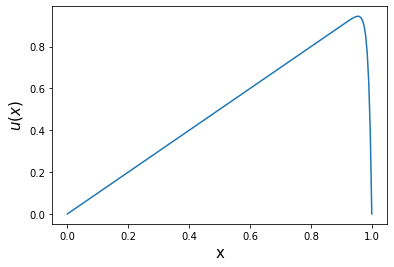

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ux = solve(f=1)
x = np.linspace(0, 1, 201)

plt.plot(x, ux)
plt.xlabel('x', fontsize=15)
plt.ylabel('$u(x)$', fontsize=15)
plt.show()

## Bayesian Calibration

In [3]:
# Define the function to calculate probability density value of given f
# the prior distribution is N ~ (1, 0.01)
def prior(f, u=1, theta=0.1):

    pf = 1/(theta*(2*np.pi)**0.5) * np.exp((-1/(2*theta**2))*(f-u))
    return pf

# Set the noisy data points for u
di = np.array([0.19, 0.37, 0.53, 0.74, 0.78, 0.63])
# Set the corresponding spatial locations (all - 1 because python indice starting from 0)
xi = np.array([50-1, 100-1, 150-1, 180-1, 190-1, 195-1])

# Define the function to calculate probability density value of the likelihood
# the likelihood distribution is N ~ (u(x,f), (0.1*d)^2), where u(x,f) = sum(u(x_i,f)), d = sum(d_i)
def likelihood(f):
    
    # solve(f) returns a list containing u(x) of given f
    u = [solve(f)[xi[i]] for i in range(len(xi))]
    gamma = 0.1*di

    exp_in = sum((1/gamma[j]**2) * (di[j] - u[j])**2 for j in range(len(xi)))

    pdf = np.exp((-1/2) * exp_in)
    return pdf
    

## Markov Chain Monte Carlo Sampling

In [4]:
# Set the std for proposal distribution N ~ (f_(n-1), a)
a = 0.19

ite = 500

f = np.zeros(ite)
accept = 0

# set the start point for Markov Chain
f[0] = 3
c = 0

for i in range(ite-1):

    f_next = np.random.normal(f[i], a)

    # compute the value for p(d|f)*p(f) and p(d|f_next)*p(f_next)
    pf = prior(f[i])
    #print(pf)
    pdf = likelihood(f[i])
    #print(pdf)
    pf_next = prior(f_next)
    pdf_next = likelihood(f_next)

    # Calculate the accepte prabobility
    accepte_prob = min(1, pf_next*pdf_next / (pf*pdf))

    # Accept the sample point with the calculated probability
    if np.random.random() < accepte_prob:
        f[i+1] = f_next
        accept += 1

    # Otherwise report the current sample point again
    else:
        f[i+1] = f[i]
    
    if i % 20 == 0:
        print(i, end= ' ')


C:\Users\wangk\AppData\Local\Temp/ipykernel_7832/2660921968.py:26: RuntimeWarning: invalid value encountered in double_scalars
  accepte_prob = min(1, pf_next*pdf_next / (pf*pdf))


0 20 40 

C:\Users\wangk\AppData\Local\Temp/ipykernel_7832/2660921968.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  accepte_prob = min(1, pf_next*pdf_next / (pf*pdf))


60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 

## Plot the MCMC trace

0.28


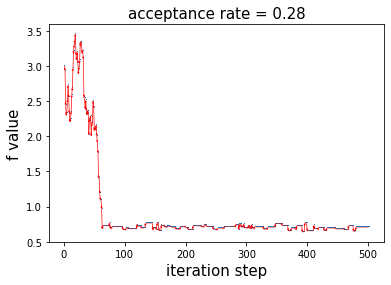

In [5]:
accep_rate = accept/ite
print(accep_rate)

x = np.linspace(1, ite+1, ite)

plt.plot(x, f, ',', zorder=1)
plt.quiver(x[:-1], f[:-1], x[1:]-x[:-1], f[1:]-f[:-1], \
            scale_units='xy', angles='xy', scale=1, color='r', width=0.002, headwidth=3, headlength=2, zorder=2)

plt.xlabel('iteration step', fontsize=15)
plt.ylabel('f value', fontsize=15)
plt.title('acceptance rate = ' + str(accep_rate), fontsize=15)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

## Compute the mean and std of MCMC sampling

In [6]:
x_mean = np.mean(f[100:])
std = np.std(f[100:])
x_mean, std

(0.7037492594567132, 0.027548281152728473)

## Plot histogram and Kernel-density estimate

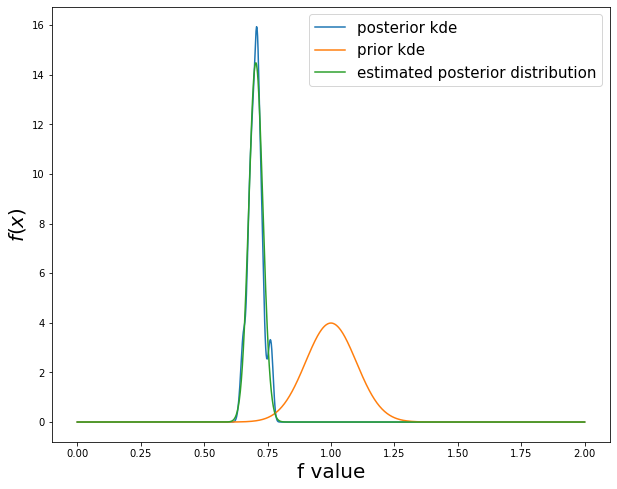

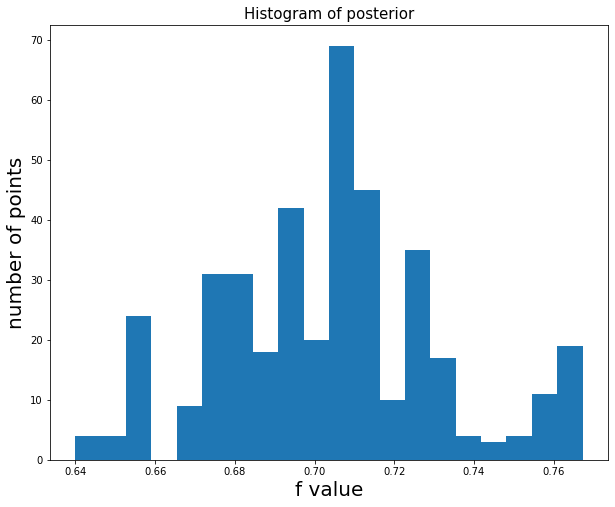

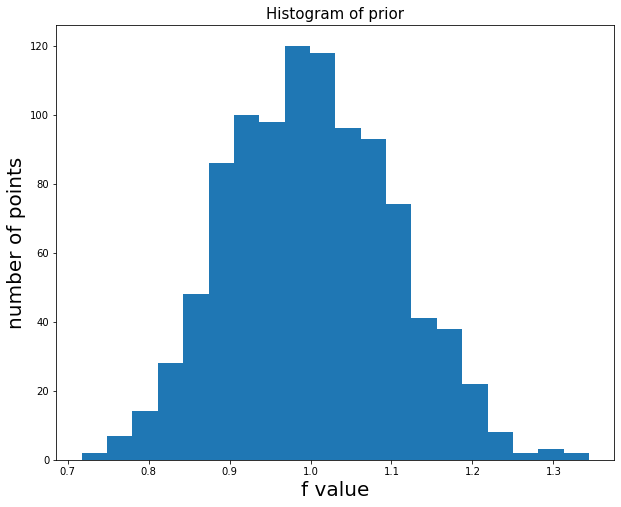

In [7]:
from scipy import stats

x_grid = np.linspace(0, 2, 1000)
sample_prior = stats.norm.pdf(x_grid, 1, 0.1)

kernel_posterior = stats.gaussian_kde(f[100:])
kde_posterior = kernel_posterior.evaluate(x_grid)

posterior_distribution = stats.norm.pdf(x_grid, x_mean, std)

plt.plot(x_grid, kde_posterior, label='posterior kde')
plt.plot(x_grid, sample_prior, label='prior kde')
plt.plot(x_grid, posterior_distribution, label='estimated posterior distribution')
plt.legend(loc='upper right', prop={'size': 15})

plt.xlabel('f value', fontsize=20)
plt.ylabel('$f(x)$', fontsize=20)
plt.show()

plt.hist(f[100:], bins=20)
plt.title('Histogram of posterior', fontsize=15)
plt.xlabel('f value', fontsize=20)
plt.ylabel('number of points', fontsize=20)
plt.show()

plt.hist(np.random.normal(1, 0.1, size=1000), bins=20)
plt.title('Histogram of prior', fontsize=15)
plt.xlabel('f value', fontsize=20)
plt.ylabel('number of points', fontsize=20)
plt.show()


## Verify u(x)

In [8]:
ux = np.zeros((len(xi), ite))
x_grid_ = np.linspace(1, ite+1, ite)

for i in range(len(xi)):
    for j in range(ite):
        ux[i][j] = solve(f=f[j])[xi[i]+1]
        
        if j % 20 == 0:
            print(j, end= ' ')

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 

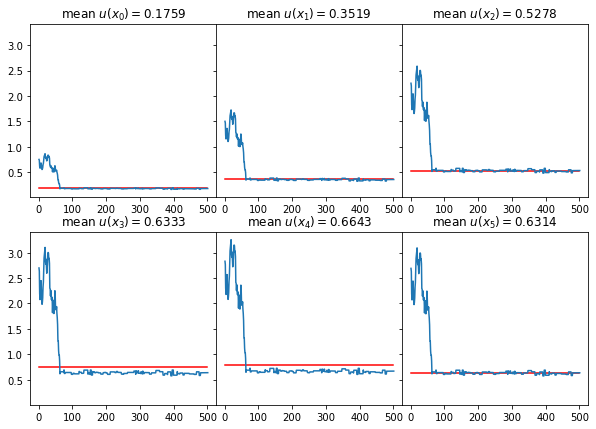

In [9]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(10, 7))
fig.subplots_adjust(wspace=0)

counter = 0

for i in range(len(ax)):
    for j in range(len(ax[1])):
        d = np.ones(ite) * di[counter]

        ax[i][j].plot(x_grid_, ux[counter], zorder=2)
        ax[i][j].plot(d, 'r', zorder=1)
        title = round(np.mean(ux[counter][100:]), 4)

        ax[i][j].set_title(f'mean $u(x_{counter}) = {title}$')

        counter += 1

In [10]:
f_ = x_mean
y = np.zeros(len(xi))

for i in range(len(xi)):
    y[i] = solve(f=f_)[xi[i]]

di = np.array([0.19, 0.37, 0.53, 0.74, 0.78, 0.63])
print(y-di)

[-0.01758143 -0.02164412 -0.0057068  -0.11015985 -0.11751013  0.01980266]
